In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
from deepcell_tracking.utils import Track, load_trks
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.5.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
def self_supervised_loss(y_true, y_pred):
    
    # Pair the current embedding with the future ground truth
    # so that we predict the future from the past
    
    current_reconstruction = y_pred
    gt = y_true
    
    loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    
    return loss

In [3]:
autoencoder = tf.keras.models.load_model('/data/models/resize_dense/resize_dense_model', custom_objects={'self_supervised_loss': self_supervised_loss})
app_encoder = tf.keras.models.load_model('/data/models/resize_dense/resize_dense_app_encoder')
embedding_model = tf.keras.models.load_model('/data/models/resize_dense/resize_dense_embedding_model')
app_decoder = tf.keras.models.load_model('/data/models/resize_dense/resize_dense_app_decoder')

In [8]:
# data loading

path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

In [9]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 1min 52s, sys: 4.1 s, total: 1min 56s
Wall time: 1min 47s


In [10]:
%%time
from deepcell_tracking.utils import concat_tracks
track_info = concat_tracks(all_tracks)

CPU times: user 1.21 s, sys: 1.97 s, total: 3.19 s
Wall time: 643 ms


In [11]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

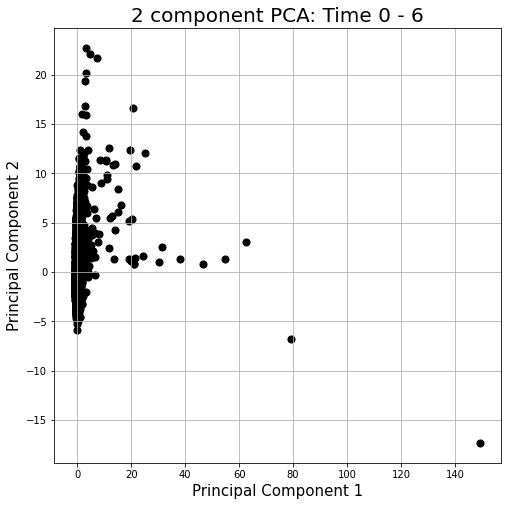

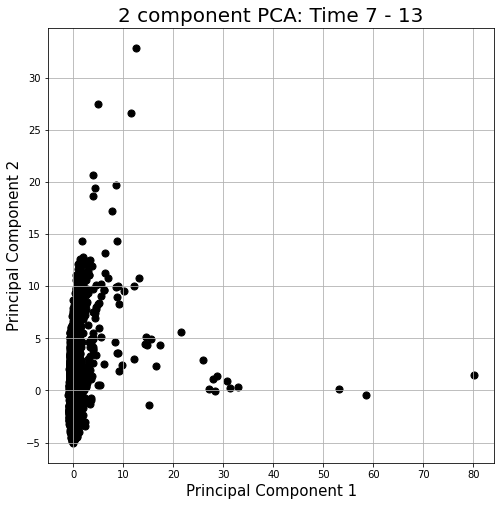

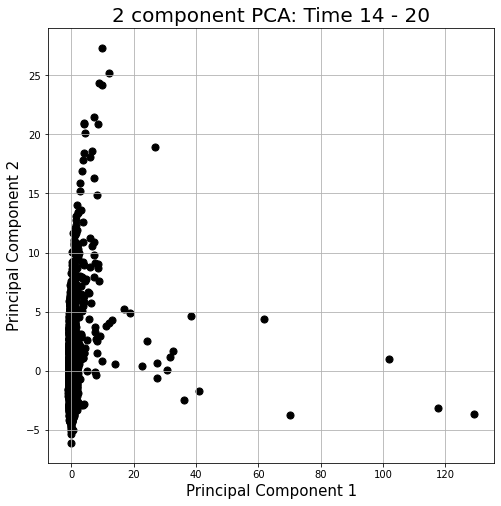

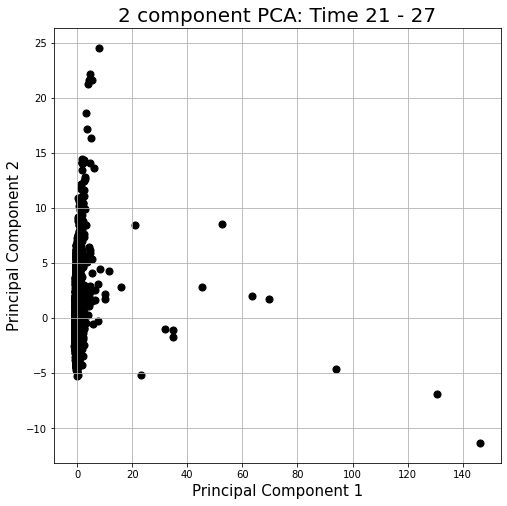

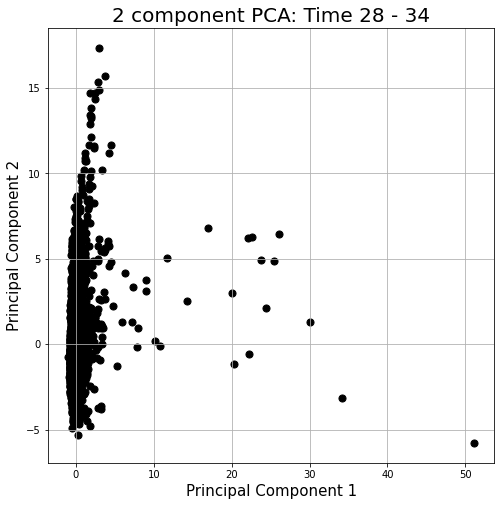

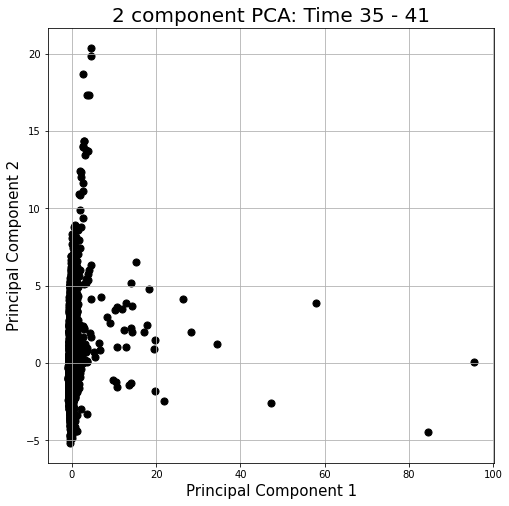

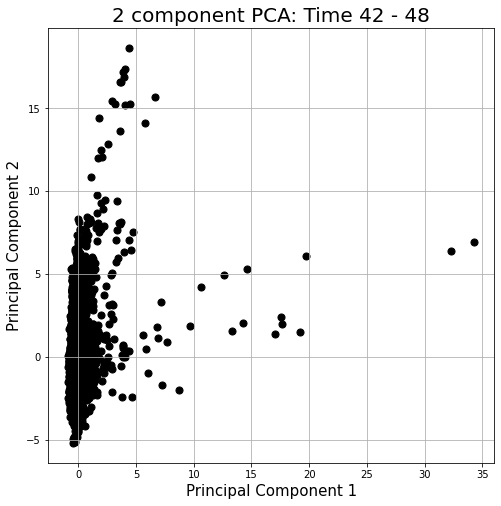

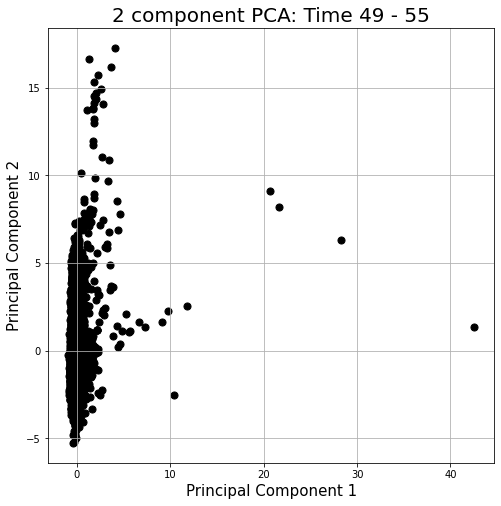

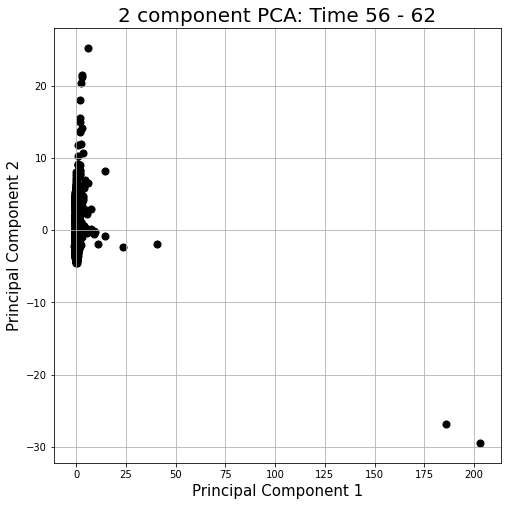

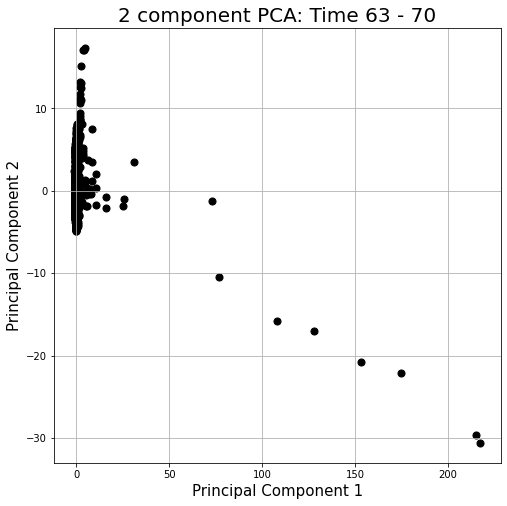

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

embedding_dim = 1024

def get_temp_embeddings_df():
    # Get data to feed forward through encoder in order of track_info['appearances']
    # Merge tracks along the batch axis
    appearances = track_info['appearances']

    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

    # Normalize appearances
    appearances = norm(appearances)

    input_dict = {'appearances': appearances}

    output_dict = {'appearances_decoder': appearances}

    data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

    data = data.repeat().batch(1)
    
    it = iter(data)

    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    num_cells = shape[0] * shape[2]

    temp_embeddings_lst = []

    for cell in range(num_cells):
        batch = cell // shape[2]
        pos = cell - shape[2] * (cell // shape[2])
        first_frame = -1
        last_frame = -1
        centroids_shape = track_info['centroids'].shape
        for frame in range(centroids_shape[1]):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                first_frame = frame
                break
        for frame in range(centroids_shape[1] - 1, -1, -1):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                last_frame = frame
                break
        
        nxt = it.next()
        if first_frame != -1:
            inputs = nxt[0]['appearances']
            app_encoded = app_encoder(inputs)
            embeddings = embedding_model(app_encoded)
            for frame in range(first_frame, last_frame + 1):
                # append time number to embedding
                time = frame - first_frame
                temp_embeddings_lst.append(np.append(embeddings[0][frame].numpy().astype('float32'), time))
            
    cols = [idx for idx in range(embedding_dim)]
    cols.append('Time')
    temp_embeddings_df = pd.DataFrame(temp_embeddings_lst, columns=cols)
    
    return temp_embeddings_df

from sklearn.preprocessing import StandardScaler

def standardize_embeddings(temp_embeddings_df):
    features = [idx for idx in range(embedding_dim)]
    embeddings = temp_embeddings_df.loc[:, features].values
    std_embeddings = StandardScaler().fit_transform(embeddings)
    
    std_embeddings_df = pd.DataFrame(std_embeddings)
    
    return std_embeddings_df

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

def project_embeddings(temp_embeddings_df):
    std_embeddings_df = standardize_embeddings(temp_embeddings_df)
    
    principal_components = pca.fit_transform(std_embeddings_df)
    principal_df = pd.DataFrame(data = principal_components, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

temp_embeddings_df = get_temp_embeddings_df()
temp_embeddings_pca_df = project_embeddings(temp_embeddings_df)

import math

shape = track_info['appearances'].shape

for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()
    plt.savefig('../embedding_graphs/resize_dense_embeddings_pca/resize_dense_embeddings_pca_' + str(time_init) + '_' + str(time_final) + '.jpg')

In [18]:
pca.explained_variance_ratio_

array([0.05691257, 0.03604715])

In [19]:
embedding_dim = 1024

cols = [idx for idx in range(embedding_dim)]
cols.append('Frame')
temp_embeddings_df.to_csv('/data/large_files/embeddings/resize_dense_embeddings.csv', header=cols)

In [20]:
cols = ['component 1', 'component 2', 'Frame']
temp_embeddings_pca_df.to_csv('/data/large_files/embeddings/resize_dense_embeddings_pca.csv', header=cols)

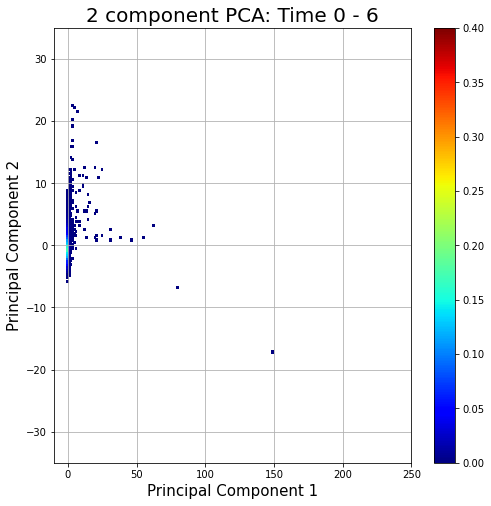

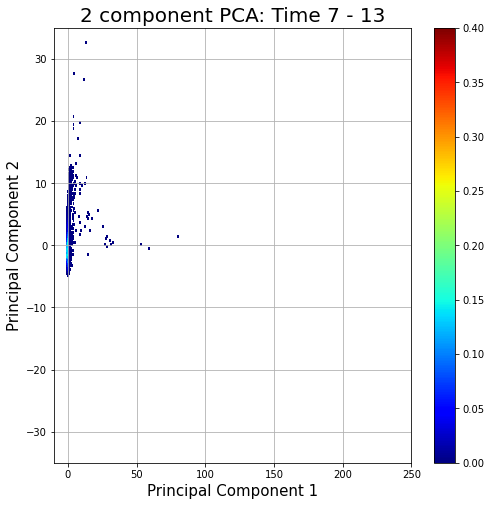

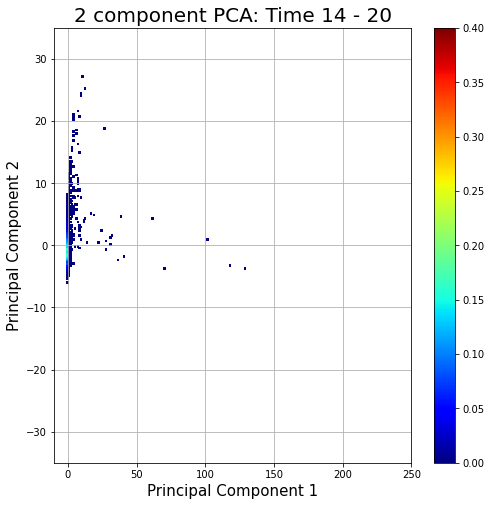

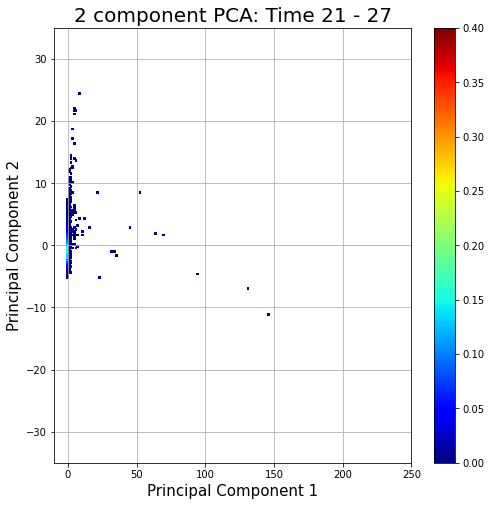

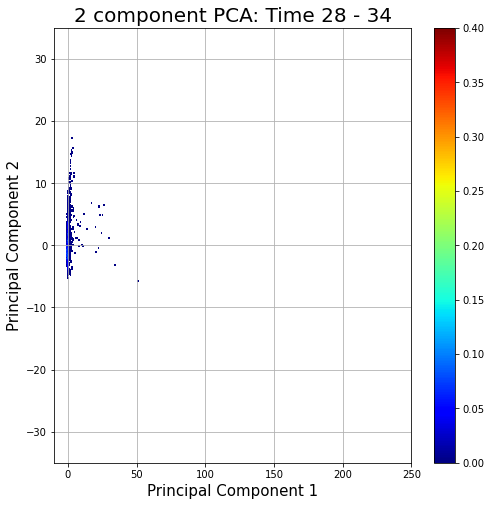

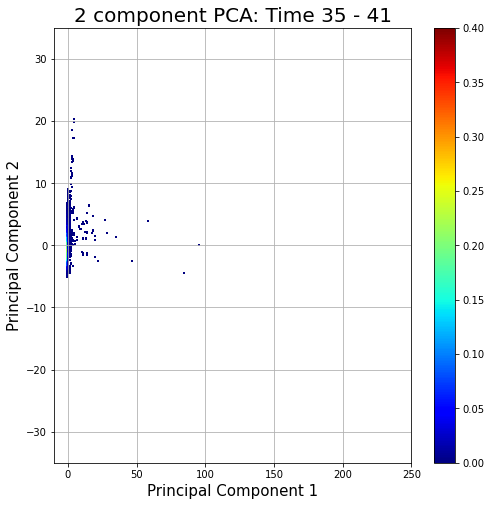

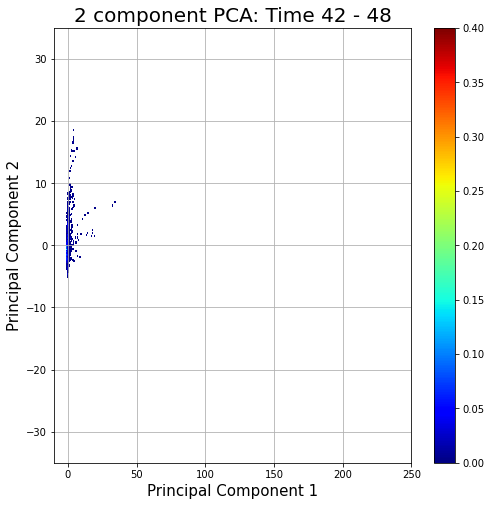

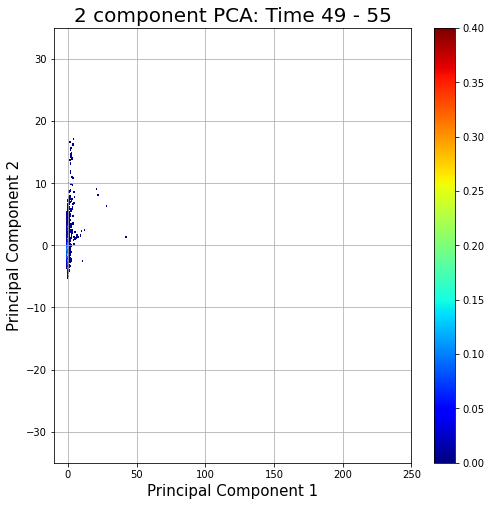

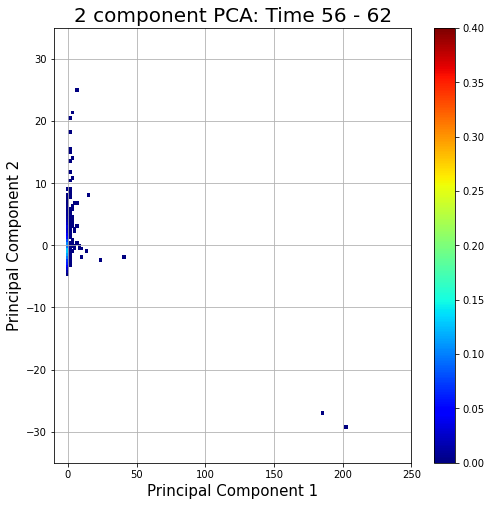

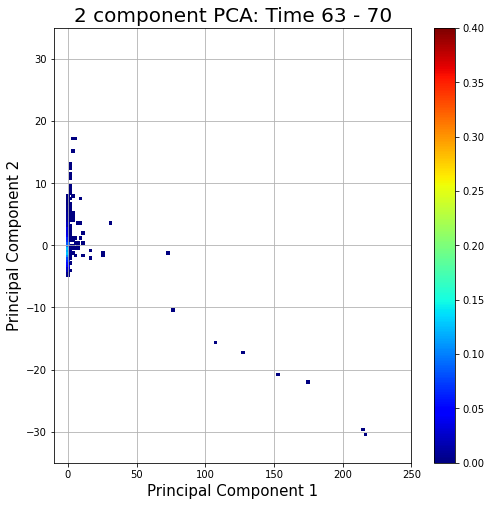

In [37]:
shape = track_info['appearances'].shape
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    x = []
    y = []
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        for x_val in temp_embeddings_pca_df.loc[indices_to_keep, 'component 1']:
            x.append(x_val)
        for y_val in temp_embeddings_pca_df.loc[indices_to_keep, 'component 2']:
            y.append(y_val)
    plt.hist2d(x, y, (120, 120), cmap=plt.cm.jet, cmin=0.00000000000000001, density=True)
    plt.colorbar()
    plt.xlim(-10, 250)
    plt.ylim(-35, 35)
    plt.clim(0, 0.4)
    ax.grid()
    plt.savefig('../embedding_graphs/resize_dense_embeddings_pca/2d_density_hists/wide/resize_dense_embeddings_pca_density_120_bins_' + str(time_init) + '_' + str(time_final) + '.jpg')

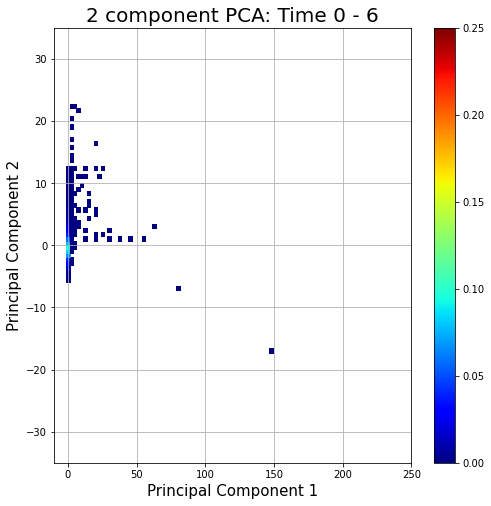

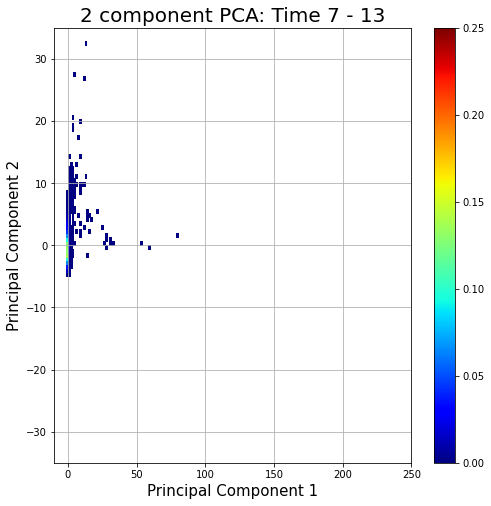

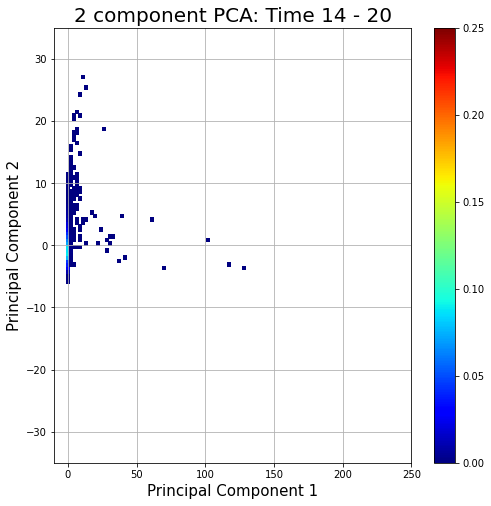

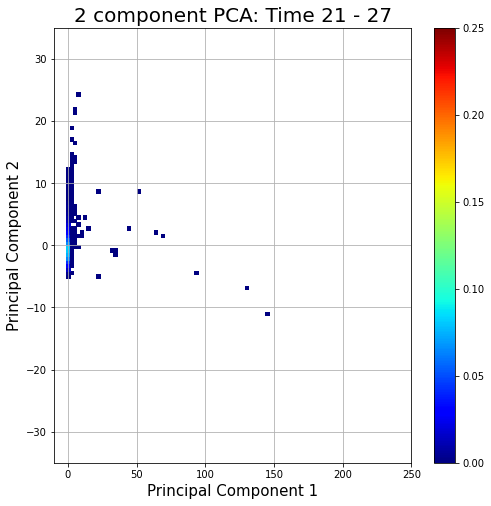

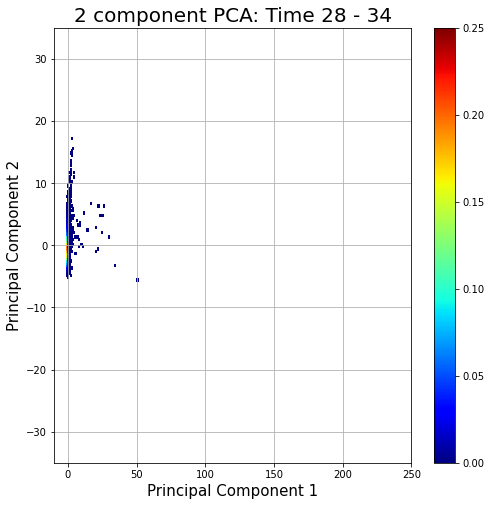

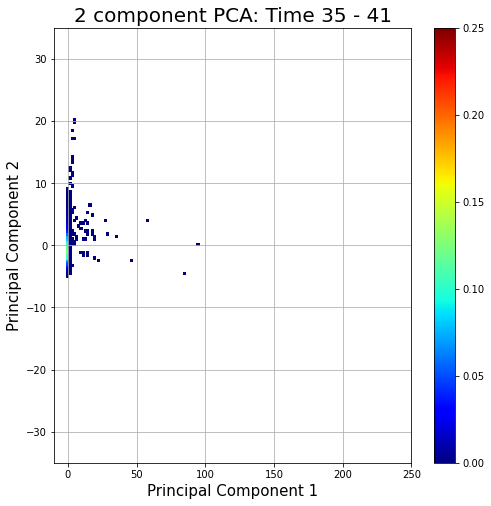

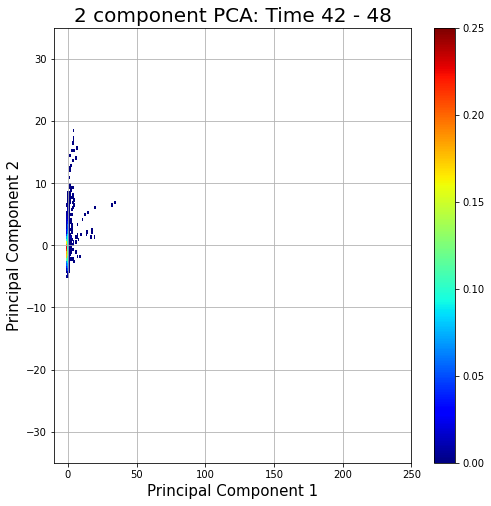

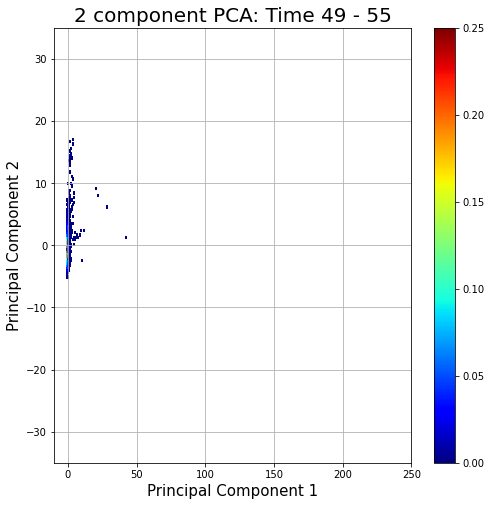

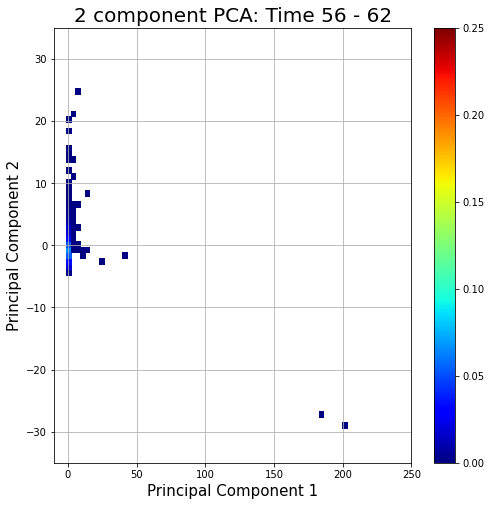

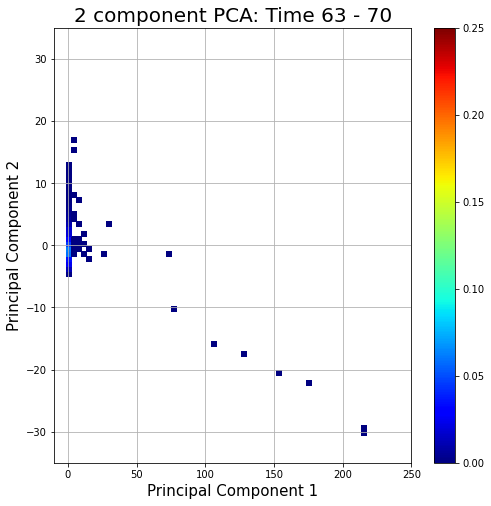

In [39]:
shape = track_info['appearances'].shape
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    x = []
    y = []
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        for x_val in temp_embeddings_pca_df.loc[indices_to_keep, 'component 1']:
            x.append(x_val)
        for y_val in temp_embeddings_pca_df.loc[indices_to_keep, 'component 2']:
            y.append(y_val)
    plt.hist2d(x, y, (60, 60), cmap=plt.cm.jet, cmin=0.00000000000000001, density=True)
    plt.colorbar()
    plt.xlim(-10, 250)
    plt.ylim(-35, 35)
    plt.clim(0, 0.25)
    ax.grid()
    plt.savefig('../embedding_graphs/resize_dense_embeddings_pca/2d_density_hists/wide/resize_dense_embeddings_pca_density_60_bins_' + str(time_init) + '_' + str(time_final) + '.jpg')

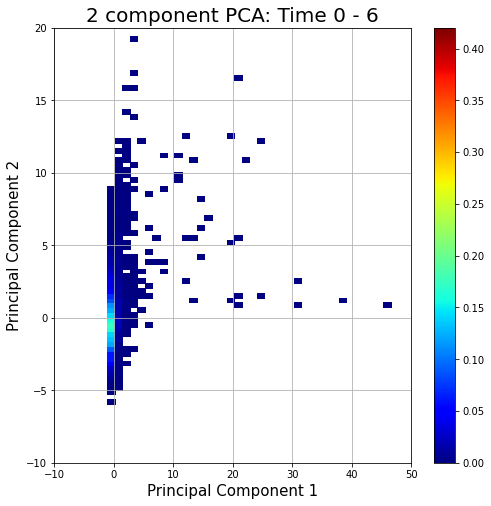

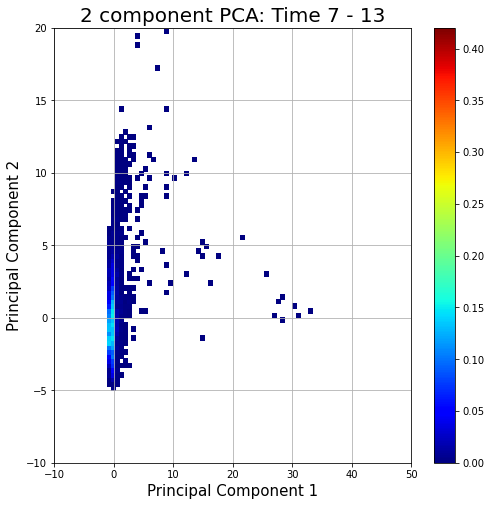

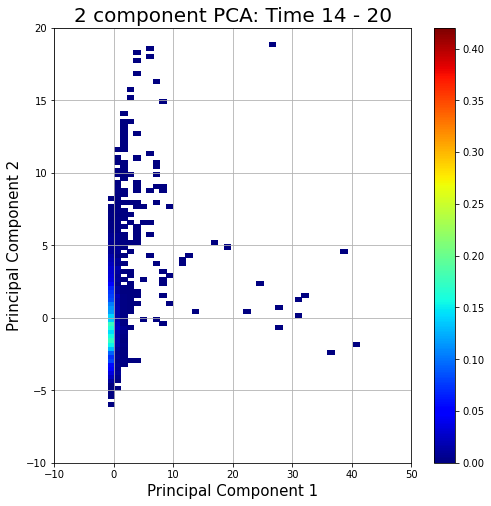

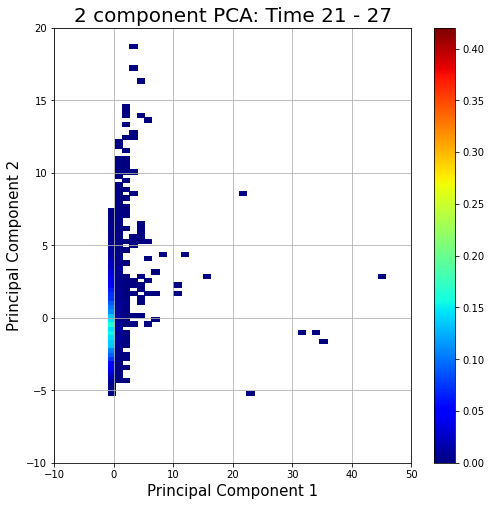

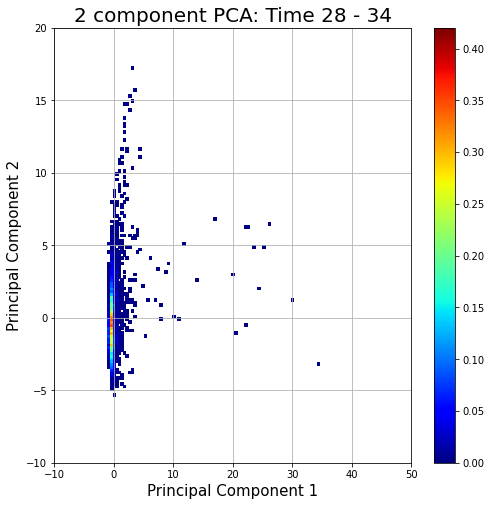

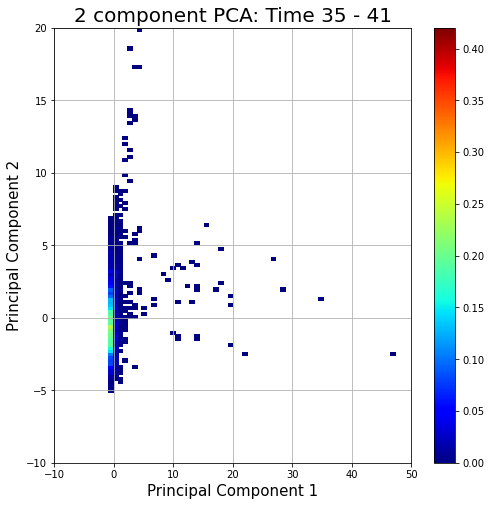

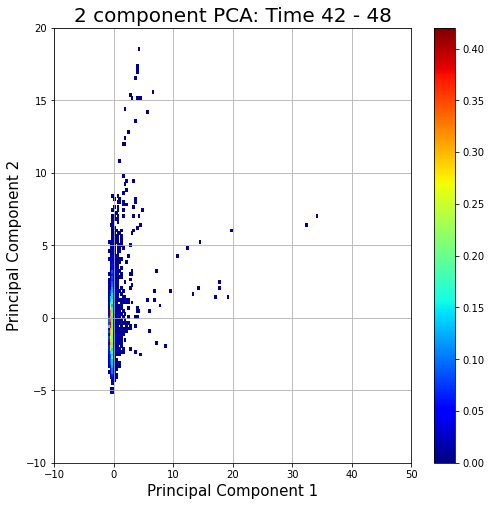

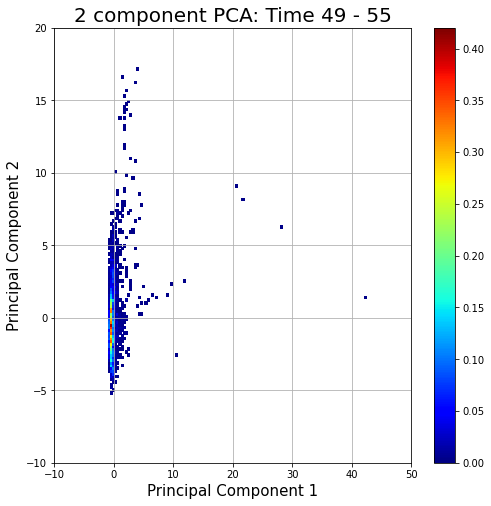

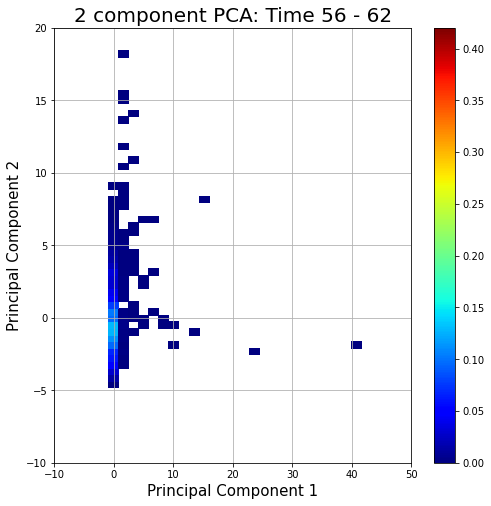

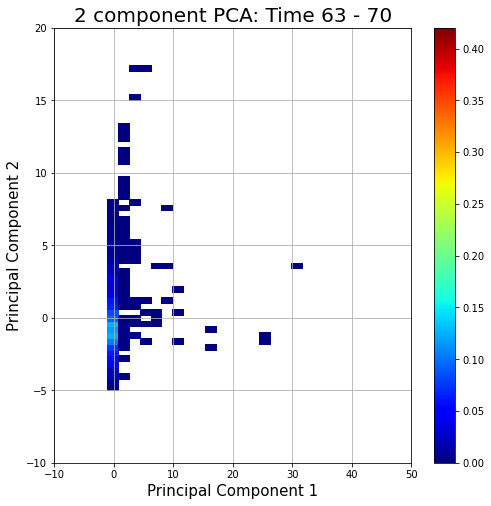

In [43]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    x = []
    y = []
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        for x_val in temp_embeddings_pca_df.loc[indices_to_keep, 'component 1']:
            x.append(x_val)
        for y_val in temp_embeddings_pca_df.loc[indices_to_keep, 'component 2']:
            y.append(y_val)
    plt.hist2d(x, y, (120, 120), cmap=plt.cm.jet, cmin=0.00000000000000001, density=True)
    plt.clim(0, 0.42)
    plt.colorbar()
    plt.xlim(-10, 50)
    plt.ylim(-10, 20)
    plt.clim(0, 0.42)
    ax.grid()
    plt.savefig('../embedding_graphs/resize_dense_embeddings_pca/2d_density_hists/zoomed/resize_dense_embeddings_pca_density_zoomed_120_bins_' + str(time_init) + '_' + str(time_final) + '.jpg')

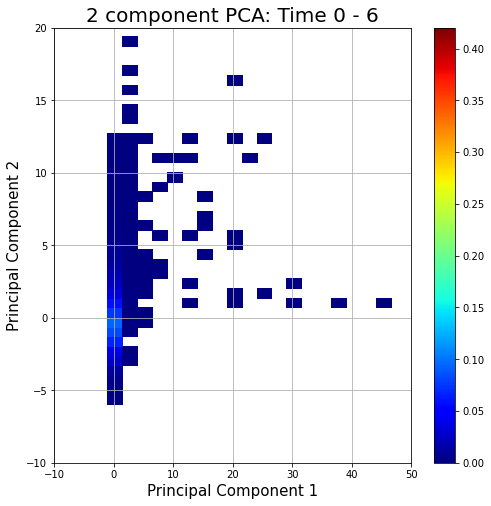

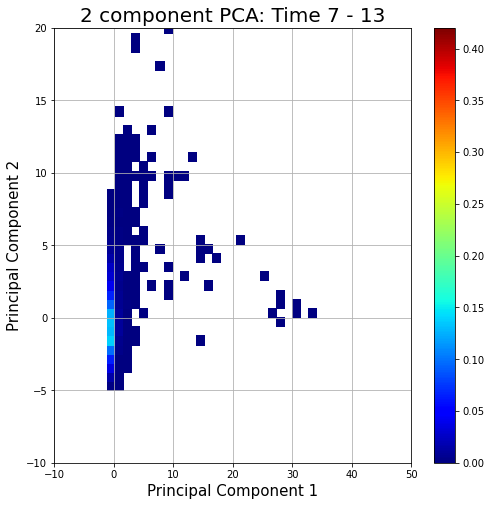

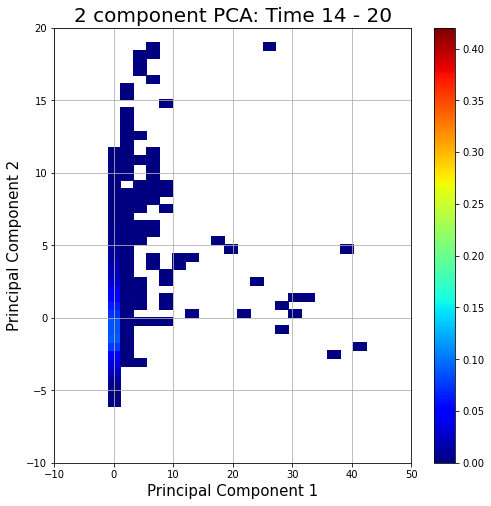

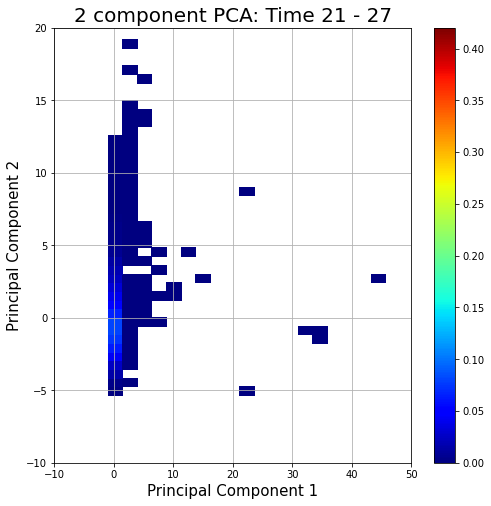

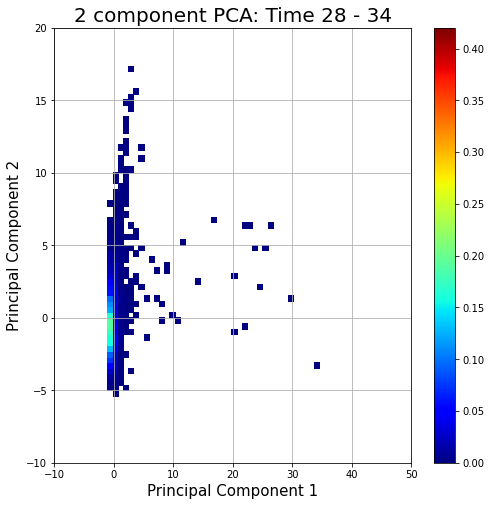

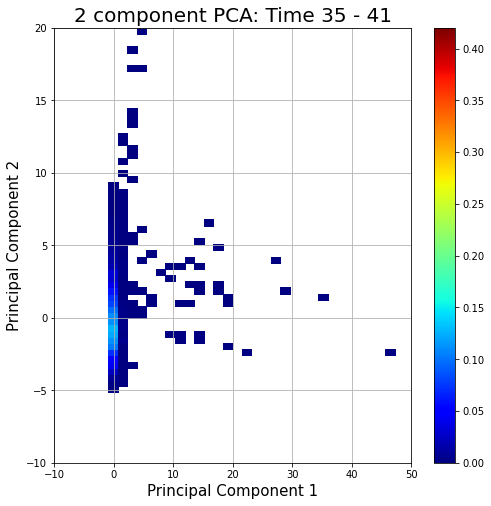

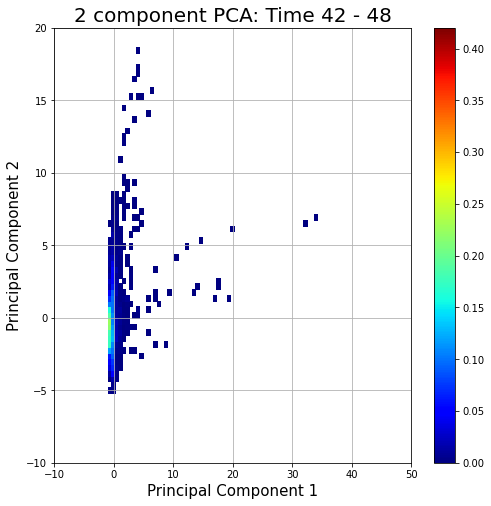

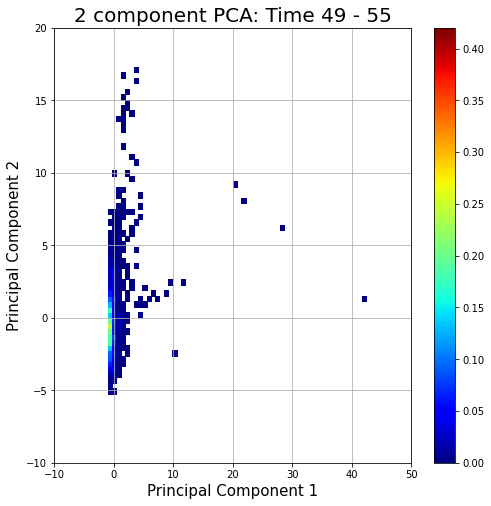

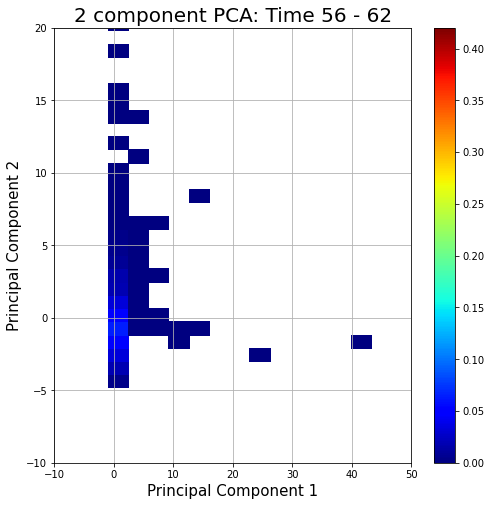

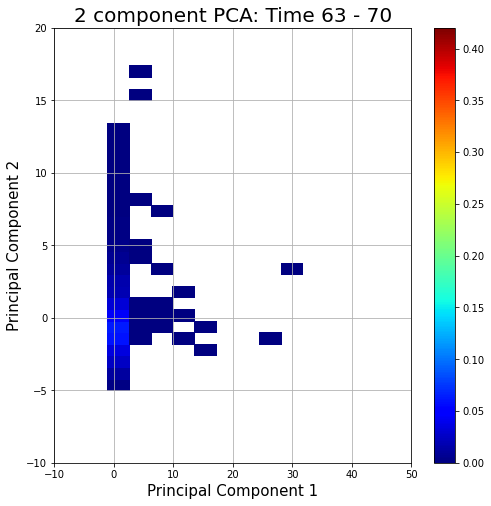

In [44]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    x = []
    y = []
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        for x_val in temp_embeddings_pca_df.loc[indices_to_keep, 'component 1']:
            x.append(x_val)
        for y_val in temp_embeddings_pca_df.loc[indices_to_keep, 'component 2']:
            y.append(y_val)
    plt.hist2d(x, y, (60, 60), cmap=plt.cm.jet, cmin=0.00000000000000001, density=True)
    plt.clim(0, 0.42)
    plt.colorbar()
    plt.xlim(-10, 50)
    plt.ylim(-10, 20)
    plt.clim(0, 0.42)
    ax.grid()
    plt.savefig('../embedding_graphs/resize_dense_embeddings_pca/2d_density_hists/zoomed/resize_dense_embeddings_pca_density_zoomed_60_bins_' + str(time_init) + '_' + str(time_final) + '.jpg')

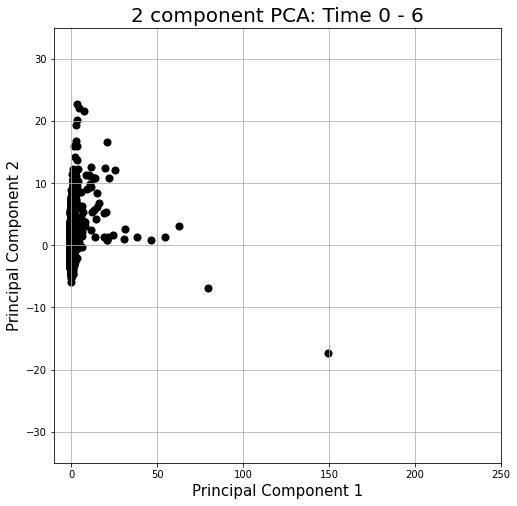

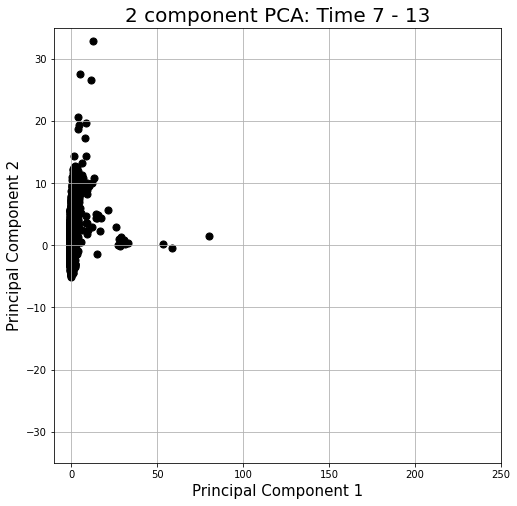

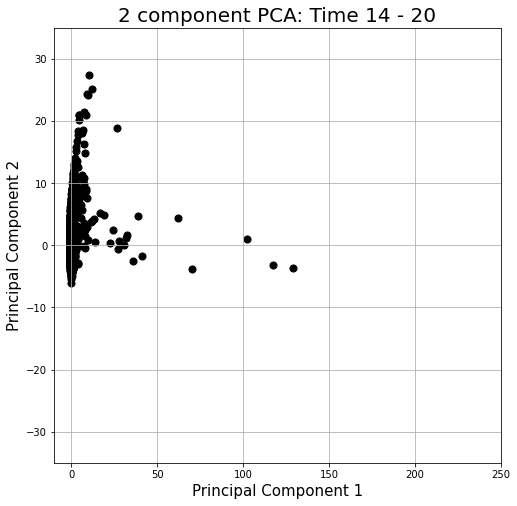

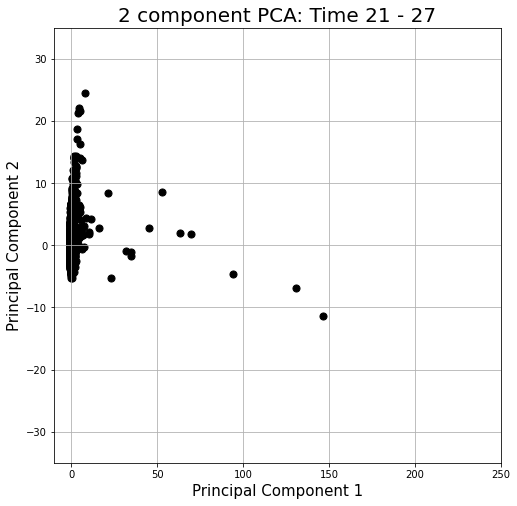

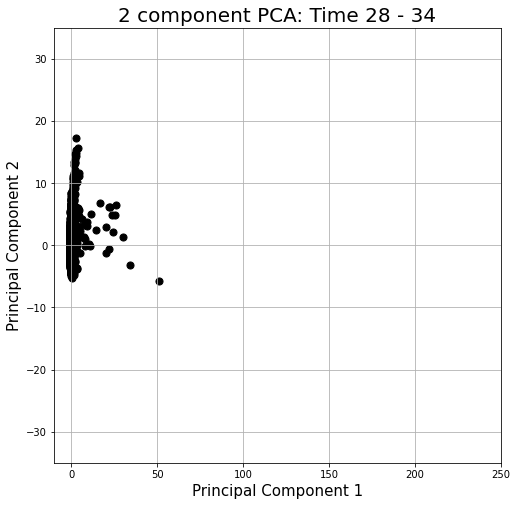

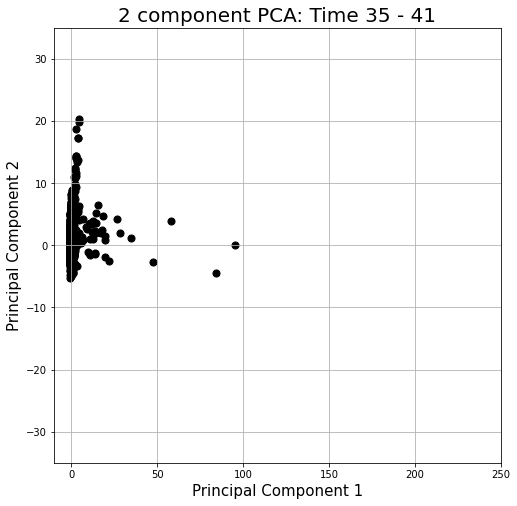

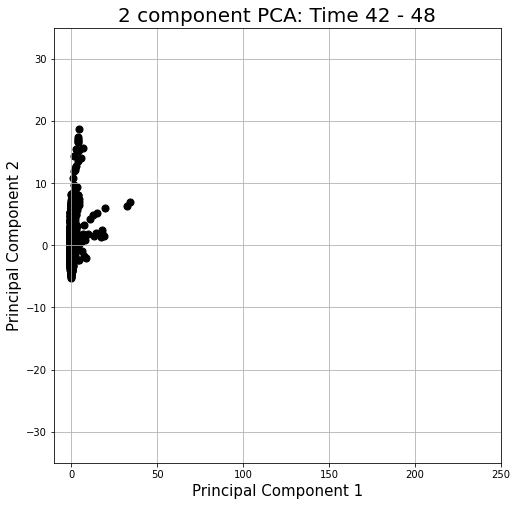

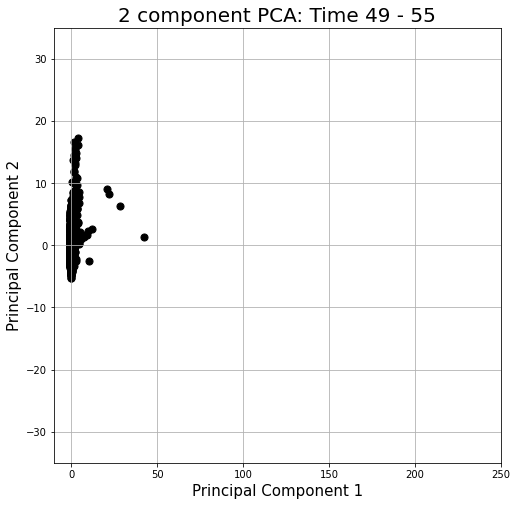

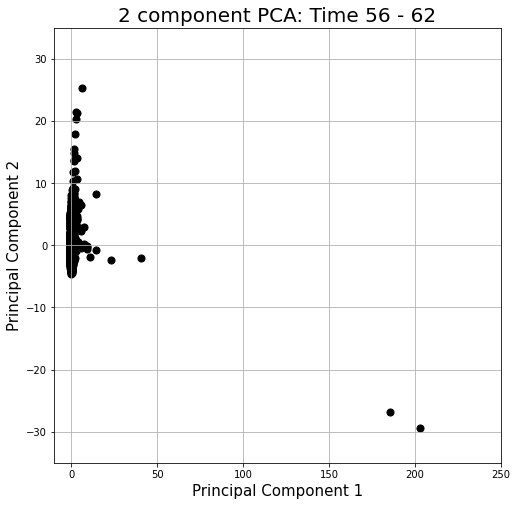

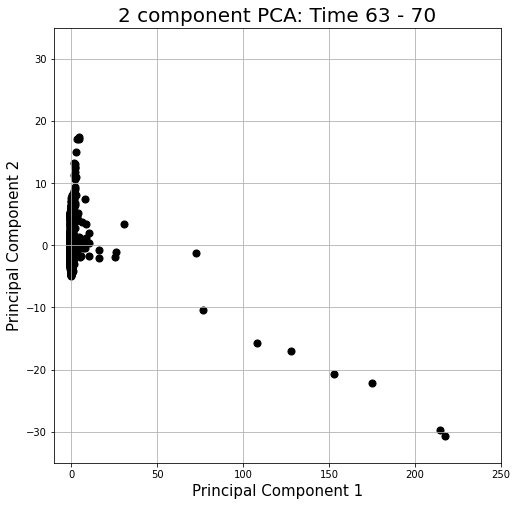

In [46]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()
    plt.xlim(-10, 250)
    plt.ylim(-35, 35)
    plt.savefig('../embedding_graphs/resize_dense_embeddings_pca/scatter_plots/set_axes/resize_dense_embeddings_pca_' + str(time_init) + '_' + str(time_final) + '.jpg')

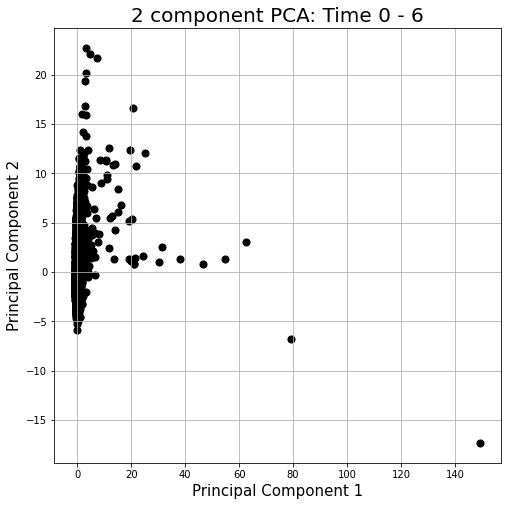

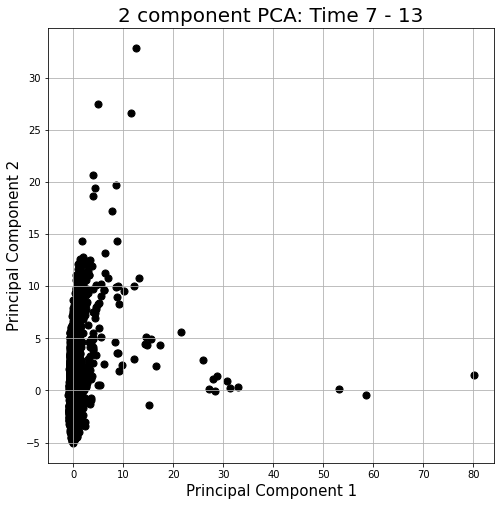

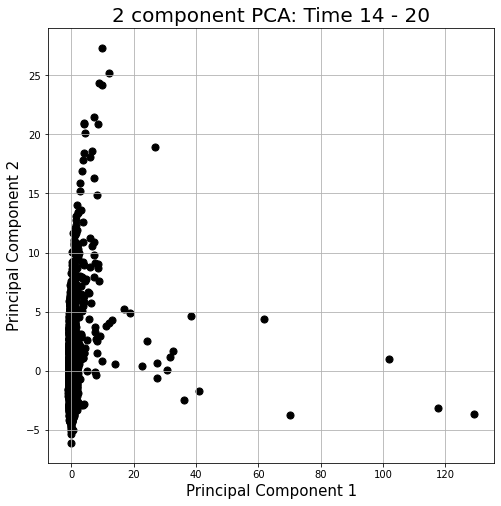

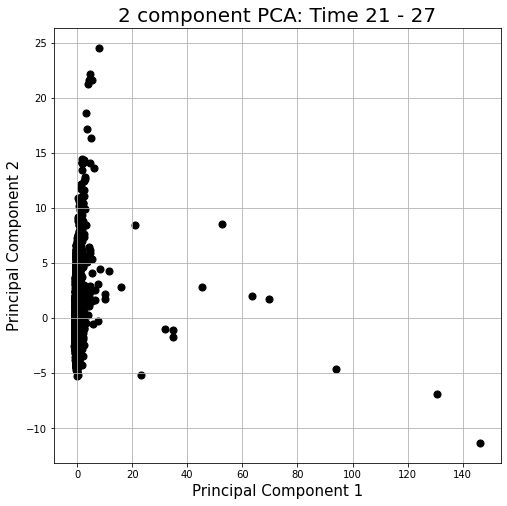

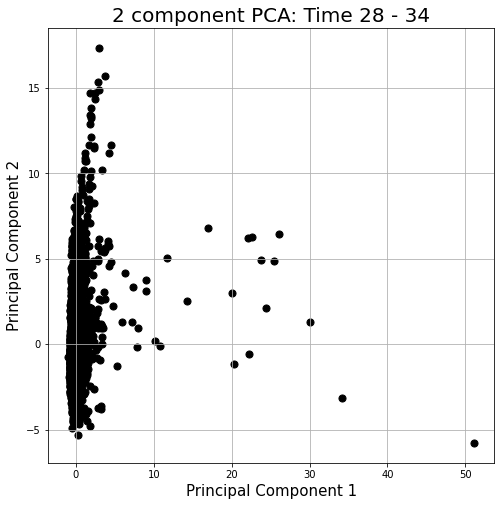

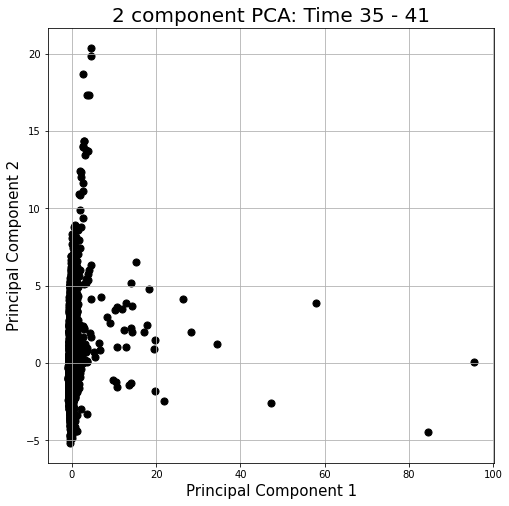

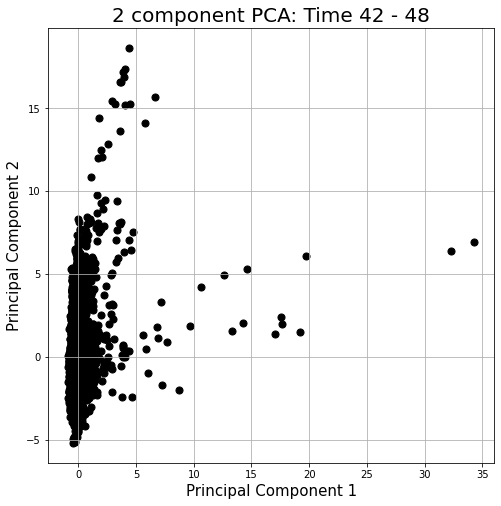

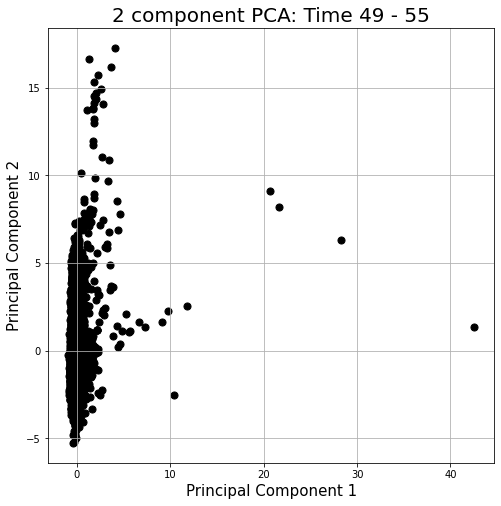

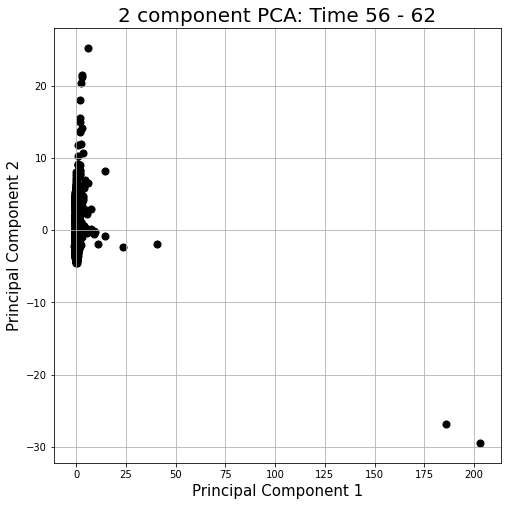

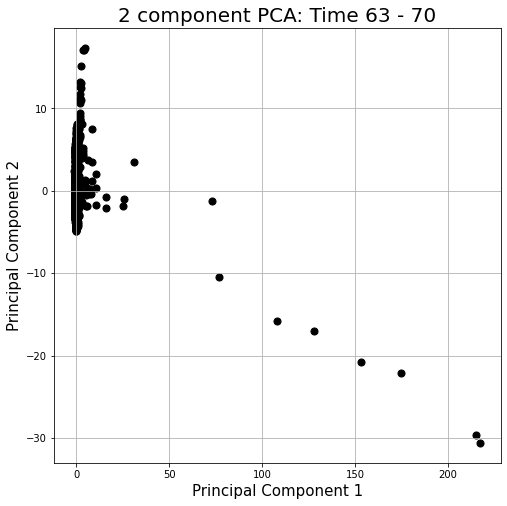

In [47]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()
    plt.savefig('../embedding_graphs/resize_dense_embeddings_pca/scatter_plots/zoomed/resize_dense_embeddings_pca_zoomed_' + str(time_init) + '_' + str(time_final) + '.jpg')